In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

In [2]:
# Torchvision datasets are in the form of PIL images with values in the range (0,1)
# we normalize the values to (-1,1) and convert them to tensor.

# transform is the Transform function we provide to the dataset loader to apply the 
# nescessary changes
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])

traindata = torchvision.datasets.CIFAR10(root='./data',download=True,train=True,transform=transform)

#trainloader is the loader that loads the data in specified manner
trainloader = torch.utils.data.DataLoader(traindata,batch_size=4,shuffle=True,num_workers=2)

testdata = torchvision.datasets.CIFAR10(root='./data',download=True,train=False,transform=transform)

testloader = torch.utils.data.DataLoader(testdata,batch_size=4,shuffle=True,num_workers=2)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


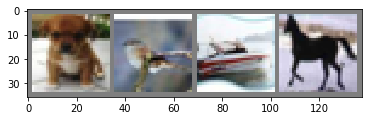

  dog  bird  ship horse


In [3]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
# create iterator to iterate over data
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Define Convolutional Neural Network 

In [12]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    
    # define the convolutional neural network and
    # it's layers. When defining you need to 
    # specify the input shape and the output shape.
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    # define the forward pass of the training. Since
    # the nn package is being used the backward pass
    # is handled by the package itself.
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1,16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## Define Loss Function and Optimizer 

In [13]:
# Here we are defining the cross entropy loss function as 
# it is a classification problem and we are also defining
# the optimizer. Here we are using the Stochastic Gradient
# Descent Optimizer and using the torch.optim package
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(),lr=0.01,momentum=0.9)

# Final Step!!!!!! :D
## Train The Network

In [14]:
for epoch in range(2):
    
    # running_loss is the loss of an epoch
    running_loss = 0.0
    
    for i, data in enumerate(trainloader, 0):
        # get the inputs and labels, data is a list of [inputs, labels]
        images, labels = data
        
        # zero the gradients
        optimizer.zero_grad()
        
        # forward pass
        outputs = net(images)
        
        # calculate loss and do backward pass
        loss = criterion(outputs, labels)
        loss.backward()
        
        #bring in the optimizer
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
            
print("Finished Training")

[1,  2000] loss: 4.163
[1,  4000] loss: 3.918
[1,  6000] loss: 3.858
[1,  8000] loss: 3.872
[1, 10000] loss: 3.864
[1, 12000] loss: 3.870
[2,  2000] loss: 3.932
[2,  4000] loss: 3.969
[2,  6000] loss: 3.961
[2,  8000] loss: 3.972
[2, 10000] loss: 3.942
[2, 12000] loss: 3.968
Finished Training


## Testing on test data   

<h4> First display some images for practice </h4>

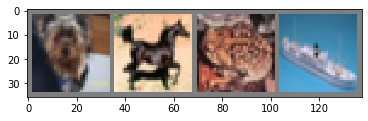

GroundTruth:    dog horse  frog  ship


In [15]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [16]:
outputs = net(images)

In [17]:
_,predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   deer  frog  deer plane


<b>Train on complete dataset</b>

In [18]:
correct = 0
total = 0

# this time we dont want to calculate the 
# gradients hence we will be using no_grad method
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

In [19]:
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 28 %


# The whole thing is working on CPU


# Training on GPU

 Define device 

In [20]:
device = torch.device("cuda")

Transfer the net as well as all the tensors to the GPU for training on GPU 

In [21]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Training The Net

In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(),lr=0.01,momentum=0.9)
for epoch in range(2):
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print()

[1,  2000] loss: 2.000
[1,  4000] loss: 1.987
[1,  6000] loss: 1.999
[1,  8000] loss: 1.982
[1, 10000] loss: 2.019
[1, 12000] loss: 2.032
[2,  2000] loss: 2.028
[2,  4000] loss: 2.046
[2,  6000] loss: 2.026
[2,  8000] loss: 2.030
[2, 10000] loss: 2.027
[2, 12000] loss: 2.156

